# Image Reconstruction: Linear Regression

Identifies masked regions in images, divides them into subregions, predicts pixel values, and evaluates reconstruction results.

In [129]:
import os
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Locate Black Region

Identifies the bounding box of the black region in an image based on pixel values. A region is valid if it contains more than a specified threshold of black pixels.

In [130]:
def locate_black_region(masked_image, threshold=20):
    """
    Identifies the bounding box of the black region in the masked image.
    Ensures accurate detection by checking for black pixels explicitly.
    """
    # Identify black pixels (threshold for very dark colors)
    black_pixels = np.where((masked_image[:, :, 0] == 0) & 
                            (masked_image[:, :, 1] == 0) & 
                            (masked_image[:, :, 2] == 0))

    if len(black_pixels[0]) > threshold:
        y_start, y_end = np.min(black_pixels[0]), np.max(black_pixels[0]) + 1
        x_start, x_end = np.min(black_pixels[1]), np.max(black_pixels[1]) + 1
        return x_start, y_start, x_end, y_end
    else:
        return None

## Split Region

Divides the identified black region into smaller subregions for localized processing.

In [131]:
def split_region(x_start, y_start, x_end, y_end, num_splits=4):
    """
    Divides the black region into smaller subregions.
    Returns a list of bounding boxes for each subregion.
    """
    subregions = []
    height = y_end - y_start
    width = x_end - x_start

    num_rows = int(np.sqrt(num_splits))  # Number of rows/columns to divide into
    step_y = height // num_rows
    step_x = width // num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            sub_x_start = x_start + j * step_x
            sub_y_start = y_start + i * step_y
            sub_x_end = sub_x_start + step_x
            sub_y_end = sub_y_start + step_y
            subregions.append((sub_x_start, sub_y_start, sub_x_end, sub_y_end))

    return subregions

## Merge Training and Validation Datasets

Merges the training and validation datasets into a single directory for training.

In [132]:
def merge_datasets(train_dir, validation_dir):
    """
    Reads images from both the training and validation directories.
    Combines their data into a single set for processing without modifying the files.
    """
    combined_files = []

    # Read training directory
    for filename in sorted(os.listdir(train_dir)):
        if filename.endswith("_masked.jpg"):
            combined_files.append((train_dir, filename))

    # Read validation directory
    for filename in sorted(os.listdir(validation_dir)):
        if filename.endswith("_masked.jpg"):
            combined_files.append((validation_dir, filename))

    return combined_files

## Prepare Training Data

Extracts features (surrounding pixel coordinates) and targets (pixel values) from the training dataset for use in regression.

In [133]:
def prepare_training_data(train_dir):
    """
    Prepares training data by extracting surrounding pixel coordinates and
    their RGB values as features. Targets are the mean RGB color of the black region.
    """
    features = []
    targets = []

    for filename in sorted(os.listdir(train_dir)):
        if filename.endswith("_masked.jpg"):
            masked_image_path = os.path.join(train_dir, filename)
            original_image_path = masked_image_path.replace("_masked", "")

            masked_image = plt.imread(masked_image_path)
            original_image = plt.imread(original_image_path)

            coords = locate_black_region(masked_image)
            if coords:
                x_start, y_start, x_end, y_end = coords

                # Calculate mean RGB color of the black square region
                region = original_image[y_start:y_end, x_start:x_end]
                mean_color = region.mean(axis=(0, 1))  # Mean RGB values (R, G, B)

                # Extract surrounding pixel coordinates
                for x in range(x_start - 1, x_end + 2):
                    for y in range(y_start - 1, y_end + 2):
                        if (
                            0 <= x < original_image.shape[1]
                            and 0 <= y < original_image.shape[0]
                        ):
                            if not (x_start <= x < x_end and y_start <= y < y_end):
                                features.append([x, y])
                                targets.append(mean_color)

    return np.array(features), np.array(targets)

## Train Regression Model

Trains a linear regression model using the prepared training data.

In [134]:
def train_regression_model(features, targets):
    """
    Trains three separate linear regression models (one for each RGB channel)
    using the provided features and targets.
    Returns the weights for each channel.
    """
    # Separate RGB channels
    targets_r = targets[:, 0]  # Red channel
    targets_g = targets[:, 1]  # Green channel
    targets_b = targets[:, 2]  # Blue channel

    # Train regressions for each channel
    weights_r = np.linalg.lstsq(features, targets_r, rcond=None)[0]
    weights_g = np.linalg.lstsq(features, targets_g, rcond=None)[0]
    weights_b = np.linalg.lstsq(features, targets_b, rcond=None)[0]

    return weights_r, weights_g, weights_b

## Perform Regression

Predicts pixel values in a black region based on surrounding pixel information using a linear regression implementation.

In [135]:
def perform_regression(original, region_coords):
    """
    Predicts pixel values in the black region using linear regression on surrounding pixels.
    """
    x_start, y_start, x_end, y_end = region_coords

    surrounding_pixels = []
    surrounding_values = []
    for x in range(x_start - 1, x_end + 2):
        for y in range(y_start - 1, y_end + 2):
            if not (x_start <= x < x_end and y_start <= y < y_end):
                surrounding_pixels.append([x, y])
                surrounding_values.append(original[y, x])

    surrounding_pixels = np.array(surrounding_pixels)
    surrounding_values = np.array(surrounding_values)

    region_pixels = []
    for x in range(x_start, x_end):
        for y in range(y_start, y_end):
            region_pixels.append([x, y])

    region_pixels = np.array(region_pixels)

    weights = np.linalg.lstsq(surrounding_pixels, surrounding_values, rcond=None)[0]
    predicted_values = np.dot(region_pixels, weights)

    reconstructed_region = np.zeros((y_end - y_start, x_end - x_start, 3), dtype=np.uint8)
    index = 0
    for y in range(reconstructed_region.shape[0]):
        for x in range(reconstructed_region.shape[1]):
            reconstructed_region[y, x] = predicted_values[index]
            index += 1

    return reconstructed_region

## Evaluate Reconstruction

Compares reconstructed images to the original images using mean squared error (MSE) and mean absolute error (MAE).

In [136]:
def evaluate_reconstruction(original, reconstructed):
    """
    Computes MSE and MAE between the original and reconstructed images.
    """
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())
    mae = mean_absolute_error(original.flatten(), reconstructed.flatten())
    return mse, mae

## Process Test Dataset

Processes a directory of images by identifying and reconstructing masked regions.

In [137]:
def process_test_data(test_dir, weights_r, weights_g, weights_b):
    """
    Processes test images and reconstructs black regions using the trained model.
    Splits the black region into 4 subregions and reconstructs each separately.
    """
    original_images = []
    masked_images = []
    reconstructed_images = []

    for filename in sorted(os.listdir(test_dir)):
        if filename.endswith("_masked.jpg"):
            masked_image_path = os.path.join(test_dir, filename)
            original_image_path = masked_image_path.replace("_masked", "")

            masked_image = plt.imread(masked_image_path)
            original_image = plt.imread(original_image_path)

            coords = locate_black_region(masked_image)
            if coords:
                x_start, y_start, x_end, y_end = coords
                reconstructed_image = masked_image.copy()

                # Split black region into 4 subregions
                subregions = split_region(x_start, y_start, x_end, y_end, num_splits=4)
                for sub_x_start, sub_y_start, sub_x_end, sub_y_end in subregions:
                    # Extract surrounding pixels
                    surrounding_pixels = []
                    for x in range(sub_x_start - 1, sub_x_end + 2):
                        for y in range(sub_y_start - 1, sub_y_end + 2):
                            if (
                                0 <= x < masked_image.shape[1]
                                and 0 <= y < masked_image.shape[0]
                            ):
                                if not (sub_x_start <= x < sub_x_end and sub_y_start <= y < sub_y_end):
                                    surrounding_pixels.append([x, y])

                    surrounding_pixels = np.array(surrounding_pixels)

                    # Predict mean RGB color for the subregion
                    if surrounding_pixels.size > 0:  # Ensure non-empty surrounding pixels
                        mean_r = np.dot(surrounding_pixels, weights_r).mean()
                        mean_g = np.dot(surrounding_pixels, weights_g).mean()
                        mean_b = np.dot(surrounding_pixels, weights_b).mean()
                    else:
                        mean_r, mean_g, mean_b = 0, 0, 0  # Default to black if no context

                    # Ensure proper RGB assignment
                    reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 0] = mean_r  # Red
                    reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 1] = mean_g  # Green
                    reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 2] = mean_b  # Blue

                original_images.append(original_image)
                masked_images.append(masked_image)
                reconstructed_images.append(reconstructed_image)

    return original_images, masked_images, reconstructed_images

## Display Results

Displays the masked and reconstructed images side by side for visual comparison.

In [138]:
def display_results(original_images, masked_images, reconstructed_images):
    """
    Displays masked and reconstructed images in a grid layout for comparison.
    """
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(10):
        if i < 5:
            axs[0, i].imshow(masked_images[i])
            axs[0, i].axis("off")
            axs[0, i].set_title(f"Masked {i+1}")

            axs[1, i].imshow(reconstructed_images[i])
            axs[1, i].axis("off")
            axs[1, i].set_title(f"Reconstructed {i+1}")
        else:
            axs[2, i - 5].imshow(masked_images[i])
            axs[2, i - 5].axis("off")
            axs[2, i - 5].set_title(f"Masked {i+1}")

            axs[3, i - 5].imshow(reconstructed_images[i])
            axs[3, i - 5].axis("off")
            axs[3, i - 5].set_title(f"Reconstructed {i+1}")

    plt.tight_layout()
    plt.show()

## Run the Reconstruction Workflow

Combines all functions to train the model using the training dataset and reconstruct masked regions in the test dataset.

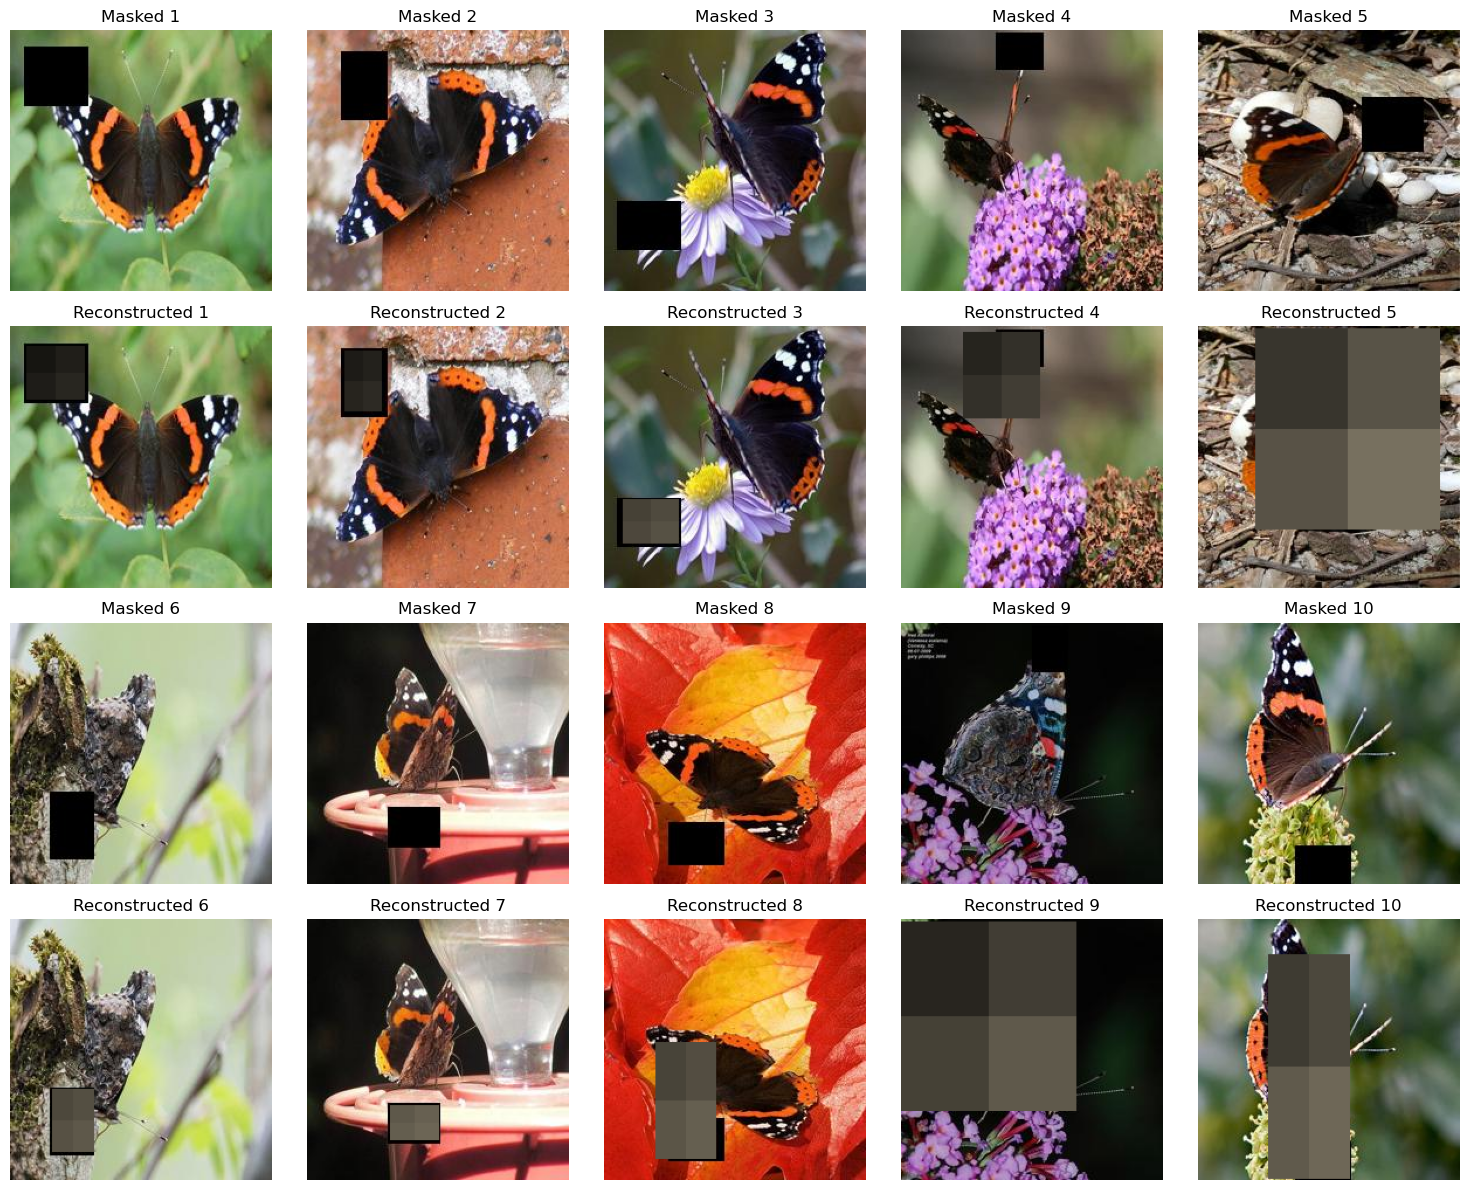

In [139]:
# Paths to dataset directories
train_dir = "Dataset/train"
validation_dir = "Dataset/validation"
test_dir = "Dataset/test"

# Prepare training data
features, targets = prepare_training_data(train_dir)

# Train regression model
weights_r, weights_g, weights_b = train_regression_model(features, targets)

# Process test dataset
original_images, masked_images, reconstructed_images = process_test_data(
    test_dir, weights_r, weights_g, weights_b
)

# Display results
display_results(original_images, masked_images, reconstructed_images)